In [ ]:
# Cell 1: Install Dependencies and Setup
!pip install -q kaggle tensorflow matplotlib seaborn scikit-learn
!pip install -q datasets pillow opencv-python
!pip install -q pycocotools
!pip install -q tensorflow-hub

import os
import zipfile
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

print("✅ Dependencies installed successfully!")
print(f"✅ TensorFlow version: {tf.__version__}")
print(f"✅ GPU Available: {tf.config.list_physical_devices('GPU')}")

# Configure GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth configured")
    except RuntimeError as e:
        print(f"⚠️ GPU configuration error: {e}")

✅ Dependencies installed successfully!
✅ TensorFlow version: 2.18.0
✅ GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ GPU memory growth configured


In [ ]:
# Cell 2: Kaggle API Setup
from google.colab import files
import json

def setup_kaggle_api():
    """Setup Kaggle API credentials"""
    print("📤 Please upload your kaggle.json file")
    uploaded = files.upload()

    if 'kaggle.json' in uploaded:
        # Create .kaggle directory
        os.makedirs('/root/.kaggle', exist_ok=True)

        # Move the file
        shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

        # Set permissions
        os.chmod('/root/.kaggle/kaggle.json', 0o600)

        print("✅ Kaggle API credentials configured successfully!")
        return True
    else:
        print("❌ kaggle.json not found. Please upload your Kaggle API credentials.")
        return False

# Setup Kaggle API
kaggle_setup = setup_kaggle_api()

if kaggle_setup:
    # Test Kaggle API
    !kaggle --version
    print("✅ Kaggle API is ready!")

📤 Please upload your kaggle.json file


Saving kaggle.json to kaggle.json
✅ Kaggle API credentials configured successfully!
Kaggle API 1.7.4.5
✅ Kaggle API is ready!


In [ ]:
# Cell 3: Download Multiple Large Datasets
import urllib.request
from concurrent.futures import ThreadPoolExecutor

def download_datasets():
    """Download multiple human detection datasets"""
    datasets = [
        {
            'name': 'Human Detection Dataset',
            'kaggle_id': 'constantinwerner/human-detection-dataset',
            'type': 'kaggle'
        },
        {
            'name': 'Human Dataset v2',
            'kaggle_id': 'fareselmenshawii/human-dataset',
            'type': 'kaggle'
        },
        {
            'name': 'Human Faces Dataset',
            'kaggle_id': 'ashwingupta3012/human-faces',
            'type': 'kaggle'
        }
    ]

    base_dir = '/content/datasets'
    os.makedirs(base_dir, exist_ok=True)

    for dataset in datasets:
        try:
            print(f"⬇️ Downloading {dataset['name']}...")
            if dataset['type'] == 'kaggle':
                download_path = os.path.join(base_dir, dataset['name'].replace(' ', '_').lower())
                os.makedirs(download_path, exist_ok=True)

                # Download using Kaggle API
                os.system(f"kaggle datasets download -d {dataset['kaggle_id']} -p {download_path} --unzip")

                print(f"✅ {dataset['name']} downloaded successfully!")
        except Exception as e:
            print(f"❌ Error downloading {dataset['name']}: {str(e)}")

    return base_dir

# Download datasets
base_dataset_dir = download_datasets()

# Additional: Download COCO dataset subset for more human images
def download_coco_subset():
    """Download COCO dataset annotations and create human/non-human subset"""
    coco_dir = '/content/coco_subset'
    os.makedirs(coco_dir, exist_ok=True)

    # Download COCO 2017 validation annotations (smaller for testing)
    print("⬇️ Downloading COCO annotations...")
    if not os.path.exists(f'{coco_dir}/annotations_trainval2017.zip'):
        os.system(f"wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P {coco_dir}")
        os.system(f"unzip {coco_dir}/annotations_trainval2017.zip -d {coco_dir}")

    # Download a subset of COCO validation images
    print("⬇️ Downloading COCO validation images...")
    if not os.path.exists(f'{coco_dir}/val2017.zip'):
        os.system(f"wget http://images.cocodataset.org/zips/val2017.zip -P {coco_dir}")
        os.system(f"unzip {coco_dir}/val2017.zip -d {coco_dir}")

    print("✅ COCO subset downloaded!")
    return coco_dir

# Download COCO subset
coco_dir = download_coco_subset()

print(f"✅ All datasets downloaded to: {base_dataset_dir}")
print(f"✅ COCO subset available at: {coco_dir}")

⬇️ Downloading Human Detection Dataset...
✅ Human Detection Dataset downloaded successfully!
⬇️ Downloading Human Dataset v2...
✅ Human Dataset v2 downloaded successfully!
⬇️ Downloading Human Faces Dataset...
✅ Human Faces Dataset downloaded successfully!
⬇️ Downloading COCO annotations...
⬇️ Downloading COCO validation images...
✅ COCO subset downloaded!
✅ All datasets downloaded to: /content/datasets
✅ COCO subset available at: /content/coco_subset


In [ ]:
# Cell 4: Process and Organize All Datasets
import json
from pycocotools.coco import COCO
import glob
from concurrent.futures import ThreadPoolExecutor

def process_coco_for_human_detection(coco_dir, output_dir):
    """Process COCO dataset to extract human/non-human images"""

    # Load COCO annotations
    ann_file = f'{coco_dir}/annotations/instances_val2017.json'
    coco = COCO(ann_file)

    # Get category ID for 'person'
    person_cat_id = coco.getCatIds(catNms=['person'])[0]

    # Get all image IDs
    all_img_ids = coco.getImgIds()

    # Get image IDs with persons
    person_img_ids = coco.getImgIds(catIds=[person_cat_id])

    # Get image IDs without persons
    non_person_img_ids = list(set(all_img_ids) - set(person_img_ids))

    # Create output directories
    human_dir = os.path.join(output_dir, 'human')
    non_human_dir = os.path.join(output_dir, 'non_human')
    os.makedirs(human_dir, exist_ok=True)
    os.makedirs(non_human_dir, exist_ok=True)

    def copy_images(img_ids, dest_dir, prefix):
        """Copy images to destination directory"""
        copied = 0
        for img_id in img_ids:
            try:
                img_info = coco.loadImgs(img_id)[0]
                src_path = f"{coco_dir}/val2017/{img_info['file_name']}"

                if os.path.exists(src_path):
                    dst_path = os.path.join(dest_dir, f"{prefix}_{img_info['file_name']}")
                    shutil.copy2(src_path, dst_path)
                    copied += 1

                    if copied >= 5000:  # Limit to prevent memory issues
                        break
            except Exception as e:
                continue
        return copied

    # Copy human images
    print("📁 Processing human images from COCO...")
    human_count = copy_images(person_img_ids, human_dir, 'coco_human')

    # Copy non-human images
    print("📁 Processing non-human images from COCO...")
    non_human_count = copy_images(non_person_img_ids, non_human_dir, 'coco_non_human')

    print(f"✅ COCO processing complete: {human_count} human, {non_human_count} non-human images")
    return human_count, non_human_count

def organize_all_datasets():
    """Organize all datasets into human/non-human structure"""

    # Create main organized directory
    organized_dir = '/content/organized_human_detection_dataset'
    raw_human_dir = os.path.join(organized_dir, 'raw', 'human')
    raw_non_human_dir = os.path.join(organized_dir, 'raw', 'non_human')

    os.makedirs(raw_human_dir, exist_ok=True)
    os.makedirs(raw_non_human_dir, exist_ok=True)

    # Process COCO dataset
    human_count, non_human_count = process_coco_for_human_detection(coco_dir, f'{organized_dir}/raw')

    # Process downloaded Kaggle datasets
    def process_kaggle_dataset(dataset_path, dataset_name):
        """Process individual Kaggle dataset"""
        print(f"📁 Processing {dataset_name}...")

        # Look for common folder structures
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_path = os.path.join(root, file)

                    # Determine if human or non-human based on folder structure
                    folder_name = os.path.basename(root).lower()
                    parent_name = os.path.basename(os.path.dirname(root)).lower()

                    # Classification logic based on folder names
                    is_human = any(keyword in folder_name or keyword in parent_name
                                 for keyword in ['human', 'person', 'people', '1', 'with_person'])

                    is_non_human = any(keyword in folder_name or keyword in parent_name
                                     for keyword in ['non_human', 'no_person', '0', 'without_person', 'background'])

                    try:
                        if is_human and not is_non_human:
                            dst_path = os.path.join(raw_human_dir, f"{dataset_name}_{file}")
                            shutil.copy2(file_path, dst_path)
                        elif is_non_human and not is_human:
                            dst_path = os.path.join(raw_non_human_dir, f"{dataset_name}_{file}")
                            shutil.copy2(file_path, dst_path)
                    except Exception as e:
                        continue

    # Process each Kaggle dataset
    kaggle_datasets = [
        ('/content/datasets/human_detection_dataset', 'kaggle_human_det'),
        ('/content/datasets/human_dataset_v2', 'kaggle_human_v2'),
        ('/content/datasets/human_faces_dataset', 'kaggle_faces')
    ]

    for dataset_path, dataset_name in kaggle_datasets:
        if os.path.exists(dataset_path):
            process_kaggle_dataset(dataset_path, dataset_name)

    # Count final images
    final_human_count = len(os.listdir(raw_human_dir))
    final_non_human_count = len(os.listdir(raw_non_human_dir))

    print(f"✅ Dataset organization complete!")
    print(f"📊 Total human images: {final_human_count}")
    print(f"📊 Total non-human images: {final_non_human_count}")
    print(f"📊 Total dataset size: {final_human_count + final_non_human_count}")

    return organized_dir, final_human_count, final_non_human_count

# Organize all datasets
organized_dataset_dir, human_count, non_human_count = organize_all_datasets()

print(f"\n✅ All datasets organized in: {organized_dataset_dir}")
print(f"📊 Final dataset composition:")
print(f"   - Human images: {human_count}")
print(f"   - Non-human images: {non_human_count}")
print(f"   - Total: {human_count + non_human_count}")

loading annotations into memory...
Done (t=0.83s)
creating index...
index created!
📁 Processing human images from COCO...
📁 Processing non-human images from COCO...
✅ COCO processing complete: 2693 human, 2307 non-human images
📁 Processing kaggle_human_det...
📁 Processing kaggle_human_v2...
📁 Processing kaggle_faces...
✅ Dataset organization complete!
📊 Total human images: 10471
📊 Total non-human images: 2307
📊 Total dataset size: 12778

✅ All datasets organized in: /content/organized_human_detection_dataset
📊 Final dataset composition:
   - Human images: 10471
   - Non-human images: 2307
   - Total: 12778


📊 Creating balanced dataset with 2307 images per class
✅ Dataset split completed:
   Train: 3690 images (1845 human, 1845 non-human)
   Val: 460 images (230 human, 230 non-human)
   Test: 464 images (232 human, 232 non-human)
Found 3690 images belonging to 2 classes.
Found 460 images belonging to 2 classes.
Found 464 images belonging to 2 classes.
✅ Data generators created successfully!
📊 Class mapping: {'human': 0, 'non_human': 1}
📊 Training samples: 3690
📊 Validation samples: 460
📊 Test samples: 464

📸 Sample augmented training images:


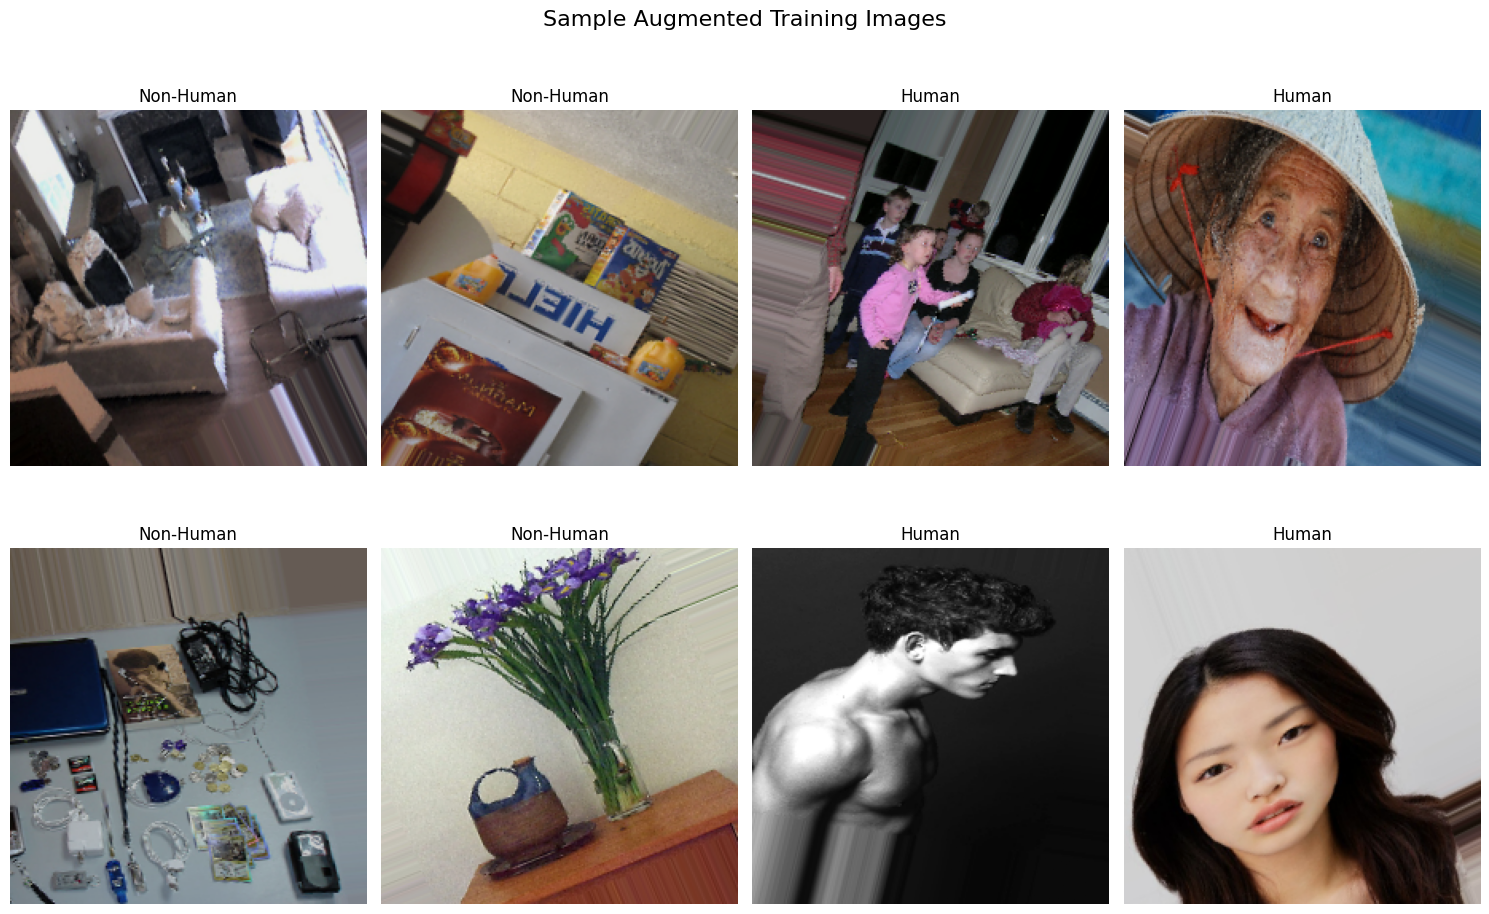

In [ ]:
# Cell 5: Advanced Data Preprocessing and Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import albumentations as A
from albumentations.pytorch import ToTensorV2

def create_balanced_dataset(organized_dir, target_size_per_class=15000):
    """Create a balanced dataset with specified size per class"""

    raw_human_dir = os.path.join(organized_dir, 'raw', 'human')
    raw_non_human_dir = os.path.join(organized_dir, 'raw', 'non_human')

    # Get all images
    human_images = [f for f in os.listdir(raw_human_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    non_human_images = [f for f in os.listdir(raw_non_human_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Balance the dataset
    min_count = min(len(human_images), len(non_human_images), target_size_per_class)

    # Randomly sample images
    human_sample = random.sample(human_images, min_count)
    non_human_sample = random.sample(non_human_images, min_count)

    print(f"📊 Creating balanced dataset with {min_count} images per class")

    # Create balanced directory structure
    balanced_dir = os.path.join(organized_dir, 'balanced')

    for split in ['train', 'val', 'test']:
        for class_name in ['human', 'non_human']:
            os.makedirs(os.path.join(balanced_dir, split, class_name), exist_ok=True)

    def split_and_copy(images, source_dir, class_name, train_ratio=0.8, val_ratio=0.1):
        """Split images into train/val/test and copy to respective directories"""

        random.shuffle(images)

        train_end = int(len(images) * train_ratio)
        val_end = train_end + int(len(images) * val_ratio)

        train_images = images[:train_end]
        val_images = images[train_end:val_end]
        test_images = images[val_end:]

        # Copy images
        for img_list, split in [(train_images, 'train'), (val_images, 'val'), (test_images, 'test')]:
            for img in img_list:
                src = os.path.join(source_dir, img)
                dst = os.path.join(balanced_dir, split, class_name, img)
                shutil.copy2(src, dst)

        return len(train_images), len(val_images), len(test_images)

    # Split human images
    h_train, h_val, h_test = split_and_copy(human_sample, raw_human_dir, 'human')

    # Split non-human images
    nh_train, nh_val, nh_test = split_and_copy(non_human_sample, raw_non_human_dir, 'non_human')

    print(f"✅ Dataset split completed:")
    print(f"   Train: {h_train + nh_train} images ({h_train} human, {nh_train} non-human)")
    print(f"   Val: {h_val + nh_val} images ({h_val} human, {nh_val} non-human)")
    print(f"   Test: {h_test + nh_test} images ({h_test} human, {nh_test} non-human)")

    return balanced_dir

def create_advanced_data_generators(data_dir, img_size=(224, 224), batch_size=32):
    """Create advanced data generators with heavy augmentation"""

    # Advanced augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest',
        brightness_range=[0.8, 1.2],
        channel_shift_range=0.2
    )

    # Minimal augmentation for validation and test
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )

    val_generator = val_test_datagen.flow_from_directory(
        os.path.join(data_dir, 'val'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=42
    )

    test_generator = val_test_datagen.flow_from_directory(
        os.path.join(data_dir, 'test'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=42
    )

    return train_generator, val_generator, test_generator

# Create balanced dataset
balanced_dataset_dir = create_balanced_dataset(organized_dataset_dir, target_size_per_class=15000)

# Create data generators
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen, val_gen, test_gen = create_advanced_data_generators(
    balanced_dataset_dir,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print(f"✅ Data generators created successfully!")
print(f"📊 Class mapping: {train_gen.class_indices}")
print(f"📊 Training samples: {train_gen.samples}")
print(f"📊 Validation samples: {val_gen.samples}")
print(f"📊 Test samples: {test_gen.samples}")

# Visualize sample augmented images
def visualize_augmented_samples(generator, num_samples=8):
    """Visualize augmented samples from the generator"""
    plt.figure(figsize=(15, 10))

    # Get a batch of images
    batch_images, batch_labels = next(generator)

    for i in range(min(num_samples, len(batch_images))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(batch_images[i])

        # Get class name
        class_idx = np.argmax(batch_labels[i])
        class_name = 'Human' if class_idx == 0 else 'Non-Human'
        plt.title(f'{class_name}')
        plt.axis('off')

    plt.suptitle('Sample Augmented Training Images', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize augmented samples
print("\n📸 Sample augmented training images:")
visualize_augmented_samples(train_gen)

In [ ]:
# Cell 6: Advanced Model Architecture with Transfer Learning
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3, ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K

def create_advanced_model(input_shape=(224, 224, 3), num_classes=2, model_name='efficientnet'):
    """Create advanced model with transfer learning"""

    # Choose base model
    if model_name == 'efficientnet':
        base_model = EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
    elif model_name == 'efficientnet_b3':
        base_model = EfficientNetB3(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
    elif model_name == 'resnet':
        base_model = ResNet50V2(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )

    # Freeze base model initially
    base_model.trainable = False

    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    predictions = Dense(num_classes, activation='softmax', name='predictions')(x)

    # Create the complete model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model, base_model

def create_ensemble_model(input_shape=(224, 224, 3), num_classes=2):
    """Create ensemble model combining multiple architectures"""

    # Create multiple base models
    efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    resnet_base = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze base models
    efficientnet_base.trainable = False
    resnet_base.trainable = False

    # EfficientNet branch
    x1 = efficientnet_base.output
    x1 = GlobalAveragePooling2D()(x1)
    x1 = Dense(256, activation='relu')(x1)
    x1 = Dropout(0.3)(x1)

    # ResNet branch
    x2 = resnet_base.output
    x2 = GlobalAveragePooling2D()(x2)
    x2 = Dense(256, activation='relu')(x2)
    x2 = Dropout(0.3)(x2)

    # Combine branches
    combined = tf.keras.layers.concatenate([x1, x2])
    combined = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(combined)
    combined = Dropout(0.5)(combined)
    combined = BatchNormalization()(combined)
    combined = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(combined)
    combined = Dropout(0.3)(combined)
    predictions = Dense(num_classes, activation='softmax')(combined)

    # Create inputs (both models use same input)
    inputs = efficientnet_base.input

    # Create ensemble model
    ensemble_model = Model(inputs=inputs, outputs=predictions)

    return ensemble_model, [efficientnet_base, resnet_base]

# Create advanced model
print("🏗️ Creating advanced model architecture...")
model, base_model = create_advanced_model(
    input_shape=(*IMG_SIZE, 3),
    num_classes=len(train_gen.class_indices),
    model_name='efficientnet'
)

# Display model summary
model.summary()

# Compile model for initial training
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("✅ Model created and compiled successfully!")

# Create advanced callbacks
def create_advanced_callbacks(model_name='best_human_detection_model'):
    """Create advanced training callbacks"""

    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=0.00001,
            verbose=1
        ),
        ModelCheckpoint(
            f"{model_name}.h5",
            save_best_only=True,
            monitor='val_accuracy',
            verbose=1,
            save_weights_only=False
        )
    ]

    return callbacks

# Create callbacks
callbacks = create_advanced_callbacks()

print("✅ Advanced callbacks created!")
print("📊 Model ready for training with:")
print(f"   - Transfer learning base: {base_model.name}")
print(f"   - Input shape: {IMG_SIZE}")
print(f"   - Number of classes: {len(train_gen.class_indices)}")
print(f"   - Batch size: {BATCH_SIZE}")

🏗️ Creating advanced model architecture...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,845,477 (18.48 MB)

 Trainable params: 791,810 (3.02 MB)

 Non-trainable params: 4,053,667 (15.46 MB)

✅ Model created and compiled successfully!
✅ Advanced callbacks created!
📊 Model ready for training with:
   - Transfer learning base: efficientnetb0
   - Input shape: (224, 224)
   - Number of classes: 2
   - Batch size: 32


🚀 Starting advanced training with fine-tuning...
🚀 Phase 1: Training with frozen base model...
Epoch 1/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.5009 - loss: 9.5218 - precision: 0.5009 - recall: 0.5009
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_human_detection_model.h5


116/116 ━━━━━━━━━━━━━━━━━━━━ 136s 926ms/step - accuracy: 0.5009 - loss: 9.5053 - precision: 0.5009 - recall: 0.5009 - val_accuracy: 0.5000 - val_loss: 4.3402 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 2/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.4943 - loss: 3.7918 - precision: 0.4943 - recall: 0.4943
Epoch 2: val_accuracy did not improve from 0.50000
116/116 ━━━━━━━━━━━━━━━━━━━━ 85s 738ms/step - accuracy: 0.4943 - loss: 3.7870 - precision: 0.4943 - recall: 0.4943 - val_accuracy: 0.5000 - val_loss: 2.2581 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 3/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.5214 - loss: 2.1117 - precision: 0.5214 - recall: 0.5214
Epoch 3: val_accuracy did not improve from 0.50000
116/116 ━━━━━━━━━━━━━━━━━━━━ 85s 731ms/step - accuracy: 0.5213 - loss: 2.1100 - precision: 0.5213 - recall: 0.5213 - val_accuracy: 0.5000 - val_loss: 1.5429 - val_precision: 0.5000 - val_recall: 

116/116 ━━━━━━━━━━━━━━━━━━━━ 85s 729ms/step - accuracy: 0.5136 - loss: 1.4710 - precision: 0.5136 - recall: 0.5136 - val_accuracy: 0.5065 - val_loss: 1.1871 - val_precision: 0.5065 - val_recall: 0.5065 - learning_rate: 0.0010
Epoch 5/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.4965 - loss: 1.1682 - precision: 0.4965 - recall: 0.4965
Epoch 5: val_accuracy did not improve from 0.50652
116/116 ━━━━━━━━━━━━━━━━━━━━ 83s 717ms/step - accuracy: 0.4965 - loss: 1.1677 - precision: 0.4965 - recall: 0.4965 - val_accuracy: 0.5043 - val_loss: 0.9966 - val_precision: 0.5043 - val_recall: 0.5043 - learning_rate: 0.0010
Epoch 6/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.5185 - loss: 0.9833 - precision: 0.5185 - recall: 0.5185
Epoch 6: val_accuracy did not improve from 0.50652
116/116 ━━━━━━━━━━━━━━━━━━━━ 83s 714ms/step - accuracy: 0.5185 - loss: 0.9831 - precision: 0.5185 - recall: 0.5185 - val_accuracy: 0.5000 - val_loss: 0.8983 - val_precision: 0.5000 - val_recall: 0

116/116 ━━━━━━━━━━━━━━━━━━━━ 84s 727ms/step - accuracy: 0.4937 - loss: 0.8045 - precision: 0.4937 - recall: 0.4937 - val_accuracy: 0.5087 - val_loss: 0.7853 - val_precision: 0.5087 - val_recall: 0.5087 - learning_rate: 0.0010
Epoch 10/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.4964 - loss: 0.7941 - precision: 0.4964 - recall: 0.4964
Epoch 10: val_accuracy improved from 0.50870 to 0.58913, saving model to best_human_detection_model.h5


116/116 ━━━━━━━━━━━━━━━━━━━━ 90s 775ms/step - accuracy: 0.4965 - loss: 0.7941 - precision: 0.4965 - recall: 0.4965 - val_accuracy: 0.5891 - val_loss: 0.7758 - val_precision: 0.5891 - val_recall: 0.5891 - learning_rate: 0.0010
Epoch 11/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.5055 - loss: 0.7871 - precision: 0.5055 - recall: 0.5055
Epoch 11: val_accuracy did not improve from 0.58913
116/116 ━━━━━━━━━━━━━━━━━━━━ 83s 721ms/step - accuracy: 0.5056 - loss: 0.7871 - precision: 0.5056 - recall: 0.5056 - val_accuracy: 0.5000 - val_loss: 0.7856 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 12/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.5287 - loss: 0.7900 - precision: 0.5287 - recall: 0.5287
Epoch 12: val_accuracy did not improve from 0.58913
116/116 ━━━━━━━━━━━━━━━━━━━━ 83s 716ms/step - accuracy: 0.5286 - loss: 0.7900 - precision: 0.5286 - recall: 0.5286 - val_accuracy: 0.5000 - val_loss: 0.7706 - val_precision: 0.5000 - val_recal

116/116 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.8260 - loss: 0.5365 - precision: 0.8260 - recall: 0.8260 - val_accuracy: 0.5109 - val_loss: 0.7651 - val_precision: 0.5109 - val_recall: 0.5109 - learning_rate: 1.0000e-04
Epoch 2/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.9160 - loss: 0.2966 - precision: 0.9160 - recall: 0.9160
Epoch 2: val_accuracy improved from 0.51087 to 0.55000, saving model to fine_tuned_human_detection_model.h5


116/116 ━━━━━━━━━━━━━━━━━━━━ 89s 765ms/step - accuracy: 0.9160 - loss: 0.2966 - precision: 0.9160 - recall: 0.9160 - val_accuracy: 0.5500 - val_loss: 0.8020 - val_precision: 0.5500 - val_recall: 0.5500 - learning_rate: 1.0000e-04
Epoch 3/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.9238 - loss: 0.2578 - precision: 0.9238 - recall: 0.9238
Epoch 3: val_accuracy improved from 0.55000 to 0.79130, saving model to fine_tuned_human_detection_model.h5


116/116 ━━━━━━━━━━━━━━━━━━━━ 88s 759ms/step - accuracy: 0.9237 - loss: 0.2578 - precision: 0.9237 - recall: 0.9237 - val_accuracy: 0.7913 - val_loss: 0.5226 - val_precision: 0.7913 - val_recall: 0.7913 - learning_rate: 1.0000e-04
Epoch 4/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9451 - loss: 0.2085 - precision: 0.9451 - recall: 0.9451
Epoch 4: val_accuracy improved from 0.79130 to 0.87826, saving model to fine_tuned_human_detection_model.h5


116/116 ━━━━━━━━━━━━━━━━━━━━ 87s 751ms/step - accuracy: 0.9451 - loss: 0.2085 - precision: 0.9451 - recall: 0.9451 - val_accuracy: 0.8783 - val_loss: 0.3789 - val_precision: 0.8783 - val_recall: 0.8783 - learning_rate: 1.0000e-04
Epoch 5/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.9420 - loss: 0.2068 - precision: 0.9420 - recall: 0.9420
Epoch 5: val_accuracy did not improve from 0.87826
116/116 ━━━━━━━━━━━━━━━━━━━━ 87s 754ms/step - accuracy: 0.9421 - loss: 0.2067 - precision: 0.9421 - recall: 0.9421 - val_accuracy: 0.5717 - val_loss: 1.1228 - val_precision: 0.5717 - val_recall: 0.5717 - learning_rate: 1.0000e-04
Epoch 6/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.9467 - loss: 0.1980 - precision: 0.9467 - recall: 0.9467
Epoch 6: val_accuracy did not improve from 0.87826
116/116 ━━━━━━━━━━━━━━━━━━━━ 87s 750ms/step - accuracy: 0.9467 - loss: 0.1980 - precision: 0.9467 - recall: 0.9467 - val_accuracy: 0.5609 - val_loss: 1.3179 - val_precision: 0.5609 - val_r

116/116 ━━━━━━━━━━━━━━━━━━━━ 89s 765ms/step - accuracy: 0.9666 - loss: 0.1422 - precision: 0.9666 - recall: 0.9666 - val_accuracy: 0.9065 - val_loss: 0.3512 - val_precision: 0.9065 - val_recall: 0.9065 - learning_rate: 1.0000e-04
Epoch 12/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.9725 - loss: 0.1286 - precision: 0.9725 - recall: 0.9725
Epoch 12: val_accuracy did not improve from 0.90652
116/116 ━━━━━━━━━━━━━━━━━━━━ 87s 752ms/step - accuracy: 0.9725 - loss: 0.1286 - precision: 0.9725 - recall: 0.9725 - val_accuracy: 0.6043 - val_loss: 7.1334 - val_precision: 0.6043 - val_recall: 0.6043 - learning_rate: 1.0000e-04
Epoch 13/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.9759 - loss: 0.1226 - precision: 0.9759 - recall: 0.9759
Epoch 13: val_accuracy did not improve from 0.90652
116/116 ━━━━━━━━━━━━━━━━━━━━ 87s 754ms/step - accuracy: 0.9759 - loss: 0.1226 - precision: 0.9759 - recall: 0.9759 - val_accuracy: 0.9065 - val_loss: 0.4192 - val_precision: 0.9065 - v

116/116 ━━━━━━━━━━━━━━━━━━━━ 90s 772ms/step - accuracy: 0.9844 - loss: 0.1024 - precision: 0.9844 - recall: 0.9844 - val_accuracy: 0.9413 - val_loss: 0.2323 - val_precision: 0.9413 - val_recall: 0.9413 - learning_rate: 1.0000e-05
Epoch 20/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.9772 - loss: 0.1018 - precision: 0.9772 - recall: 0.9772
Epoch 20: val_accuracy improved from 0.94130 to 0.95000, saving model to fine_tuned_human_detection_model.h5


116/116 ━━━━━━━━━━━━━━━━━━━━ 89s 764ms/step - accuracy: 0.9772 - loss: 0.1017 - precision: 0.9772 - recall: 0.9772 - val_accuracy: 0.9500 - val_loss: 0.2061 - val_precision: 0.9500 - val_recall: 0.9500 - learning_rate: 1.0000e-05
Epoch 21/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.9806 - loss: 0.1055 - precision: 0.9806 - recall: 0.9806
Epoch 21: val_accuracy improved from 0.95000 to 0.95217, saving model to fine_tuned_human_detection_model.h5


116/116 ━━━━━━━━━━━━━━━━━━━━ 88s 761ms/step - accuracy: 0.9807 - loss: 0.1054 - precision: 0.9807 - recall: 0.9807 - val_accuracy: 0.9522 - val_loss: 0.2016 - val_precision: 0.9522 - val_recall: 0.9522 - learning_rate: 1.0000e-05
Epoch 22/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.9887 - loss: 0.0811 - precision: 0.9887 - recall: 0.9887
Epoch 22: val_accuracy did not improve from 0.95217
116/116 ━━━━━━━━━━━━━━━━━━━━ 89s 764ms/step - accuracy: 0.9887 - loss: 0.0811 - precision: 0.9887 - recall: 0.9887 - val_accuracy: 0.9500 - val_loss: 0.2001 - val_precision: 0.9500 - val_recall: 0.9500 - learning_rate: 1.0000e-05
Epoch 23/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9895 - loss: 0.0778 - precision: 0.9895 - recall: 0.9895
Epoch 23: val_accuracy improved from 0.95217 to 0.95435, saving model to fine_tuned_human_detection_model.h5


116/116 ━━━━━━━━━━━━━━━━━━━━ 93s 800ms/step - accuracy: 0.9895 - loss: 0.0778 - precision: 0.9895 - recall: 0.9895 - val_accuracy: 0.9543 - val_loss: 0.1975 - val_precision: 0.9543 - val_recall: 0.9543 - learning_rate: 1.0000e-05
Epoch 24/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.9865 - loss: 0.0812 - precision: 0.9865 - recall: 0.9865
Epoch 24: val_accuracy did not improve from 0.95435
116/116 ━━━━━━━━━━━━━━━━━━━━ 87s 751ms/step - accuracy: 0.9865 - loss: 0.0812 - precision: 0.9865 - recall: 0.9865 - val_accuracy: 0.9413 - val_loss: 0.2179 - val_precision: 0.9413 - val_recall: 0.9413 - learning_rate: 1.0000e-05
Epoch 25/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.9932 - loss: 0.0679 - precision: 0.9932 - recall: 0.9932
Epoch 25: val_accuracy did not improve from 0.95435
116/116 ━━━━━━━━━━━━━━━━━━━━ 88s 755ms/step - accuracy: 0.9931 - loss: 0.0680 - precision: 0.9931 - recall: 0.9931 - val_accuracy: 0.9478 - val_loss: 0.2235 - val_precision: 0.9478 - v

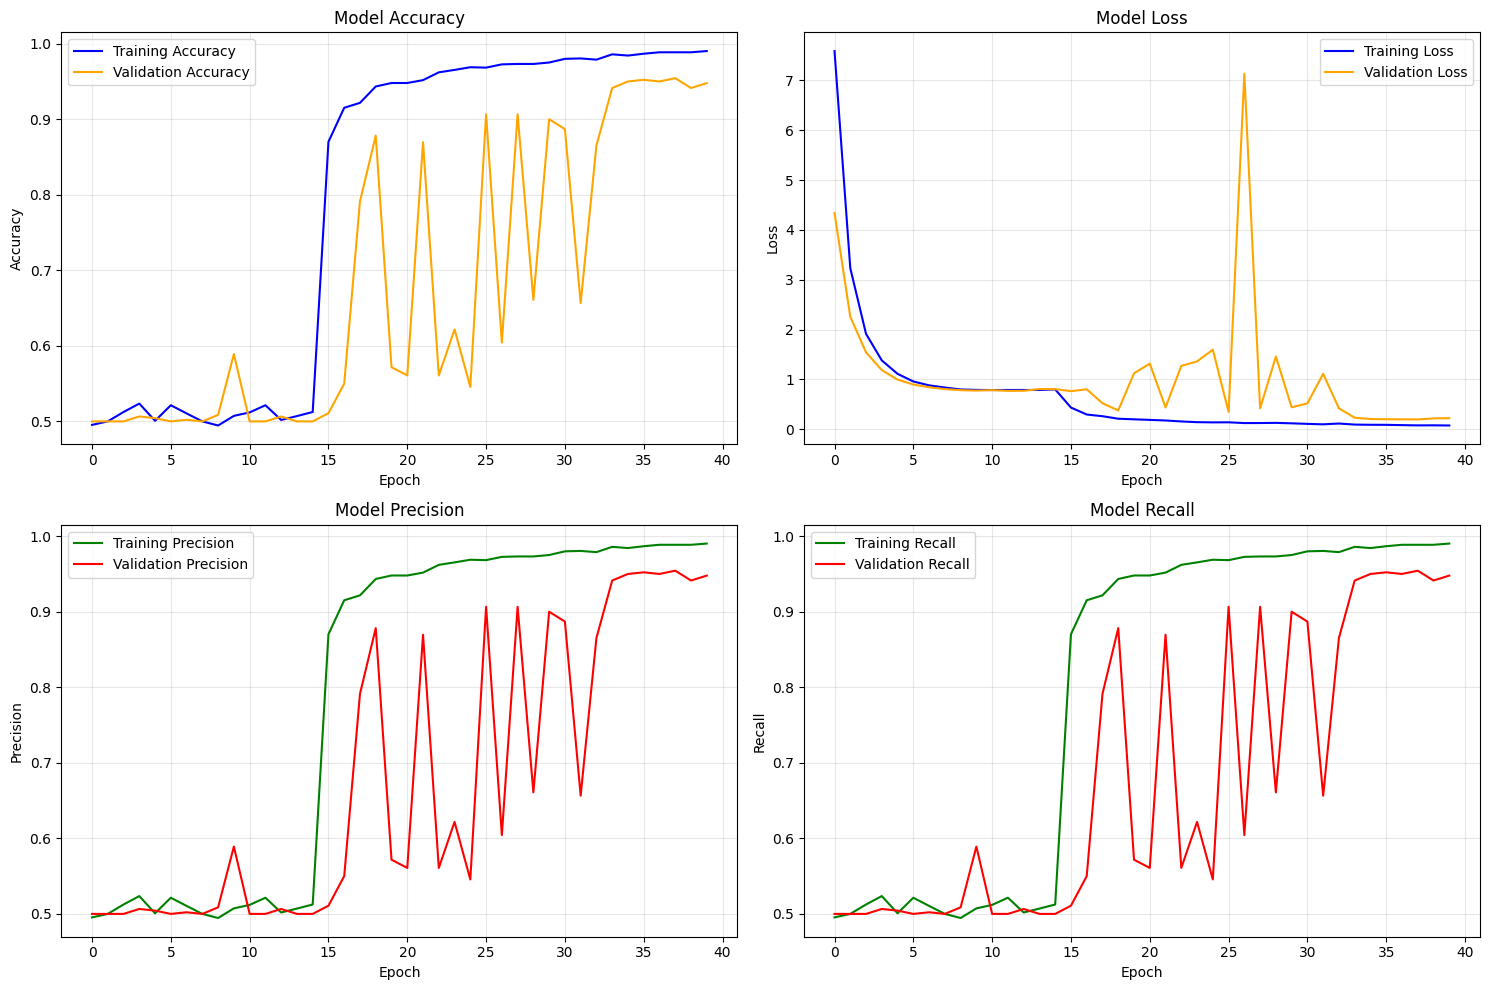


📊 Final Training Metrics (Epoch 40):
   Training Accuracy: 0.9902
   Validation Accuracy: 0.9478
   Training Loss: 0.0760
   Validation Loss: 0.2235
   Training Precision: 0.9902
   Validation Precision: 0.9478
   Training Recall: 0.9902
   Validation Recall: 0.9478
✅ Training visualization complete!


In [ ]:
# Cell 7: Advanced Training with Fine-tuning
import time
from tensorflow.keras.optimizers import SGD

def train_with_fine_tuning(model, base_model, train_gen, val_gen, callbacks):
    """Train model with two-phase approach: freeze then fine-tune"""

    print("🚀 Phase 1: Training with frozen base model...")

    # Phase 1: Train with frozen base model
    history_phase1 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=15,
        callbacks=callbacks,
        verbose=1
    )

    print("\n🔥 Phase 2: Fine-tuning entire model...")

    # Phase 2: Unfreeze base model and fine-tune
    base_model.trainable = True

    # Use lower learning rate for fine-tuning
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    # Create new callbacks for fine-tuning
    fine_tune_callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=7,
            min_lr=0.000001,
            verbose=1
        ),
        ModelCheckpoint(
            "fine_tuned_human_detection_model.h5",
            save_best_only=True,
            monitor='val_accuracy',
            verbose=1
        )
    ]

    # Continue training with fine-tuning
    history_phase2 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=25,
        callbacks=fine_tune_callbacks,
        verbose=1
    )

    # Combine histories
    combined_history = {}
    for key in history_phase1.history.keys():
        combined_history[key] = history_phase1.history[key] + history_phase2.history[key]

    return combined_history

# Start advanced training
print("🚀 Starting advanced training with fine-tuning...")
start_time = time.time()

# Train the model
training_history = train_with_fine_tuning(
    model=model,
    base_model=base_model,
    train_gen=train_gen,
    val_gen=val_gen,
    callbacks=callbacks
)

end_time = time.time()
training_duration = end_time - start_time

print(f"\n✅ Training completed in {training_duration/60:.2f} minutes!")

# Plot comprehensive training history
def plot_training_history(history, save_path='training_history.png'):
    """Plot comprehensive training history"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot accuracy
    axes[0, 0].plot(history['accuracy'], label='Training Accuracy', color='blue')
    axes[0, 0].plot(history['val_accuracy'], label='Validation Accuracy', color='orange')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot loss
    axes[0, 1].plot(history['loss'], label='Training Loss', color='blue')
    axes[0, 1].plot(history['val_loss'], label='Validation Loss', color='orange')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot precision
    axes[1, 0].plot(history['precision'], label='Training Precision', color='green')
    axes[1, 0].plot(history['val_precision'], label='Validation Precision', color='red')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot recall
    axes[1, 1].plot(history['recall'], label='Training Recall', color='green')
    axes[1, 1].plot(history['val_recall'], label='Validation Recall', color='red')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Print final metrics
    final_epoch = len(history['accuracy']) - 1
    print(f"\n📊 Final Training Metrics (Epoch {final_epoch + 1}):")
    print(f"   Training Accuracy: {history['accuracy'][final_epoch]:.4f}")
    print(f"   Validation Accuracy: {history['val_accuracy'][final_epoch]:.4f}")
    print(f"   Training Loss: {history['loss'][final_epoch]:.4f}")
    print(f"   Validation Loss: {history['val_loss'][final_epoch]:.4f}")
    print(f"   Training Precision: {history['precision'][final_epoch]:.4f}")
    print(f"   Validation Precision: {history['val_precision'][final_epoch]:.4f}")
    print(f"   Training Recall: {history['recall'][final_epoch]:.4f}")
    print(f"   Validation Recall: {history['val_recall'][final_epoch]:.4f}")

# Plot training history
plot_training_history(training_history)

print("✅ Training visualization complete!")

📁 Loading best trained model...


✅ Fine-tuned model loaded successfully!
🔍 Performing comprehensive model evaluation...
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 763ms/step

📊 Test Set Performance:
   Test Accuracy: 0.9504 (95.04%)
   Test Loss: 0.2805
   Test Precision: 0.9504
   Test Recall: 0.9504
   Test F1-Score: 0.9504

📋 Detailed Classification Report:
              precision    recall  f1-score   support

       Human       0.98      0.92      0.95       232
   Non-Human       0.93      0.98      0.95       232

    accuracy                           0.95       464
   macro avg       0.95      0.95      0.95       464
weighted avg       0.95      0.95      0.95       464



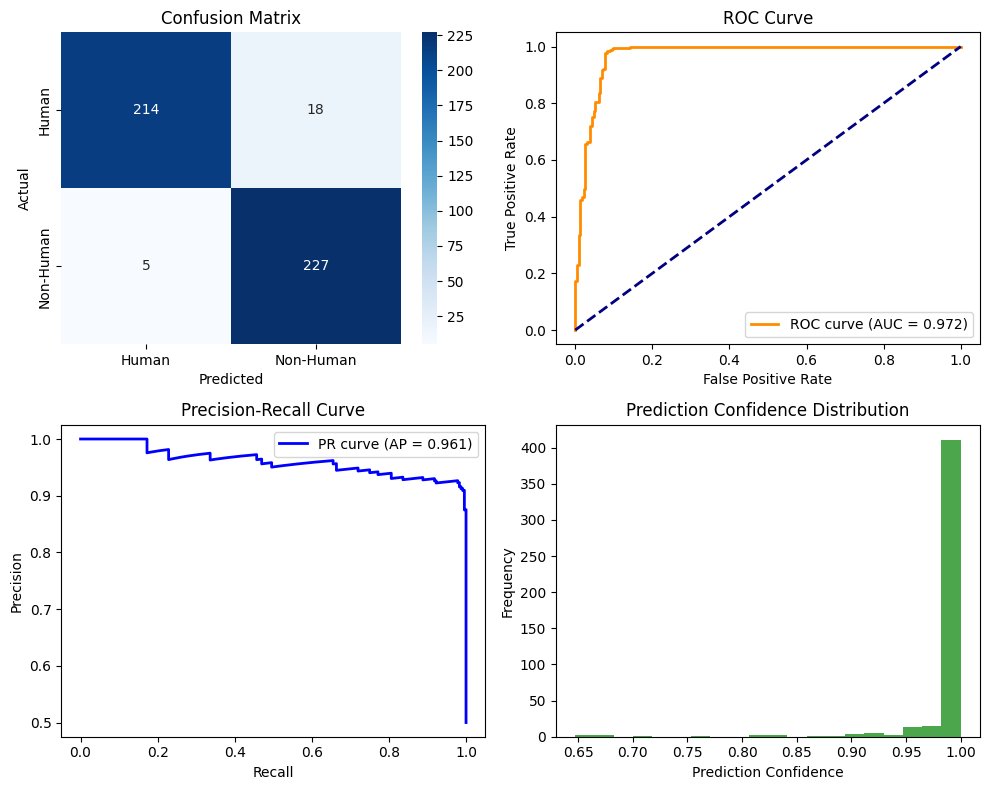

🔍 Analyzing misclassified samples...


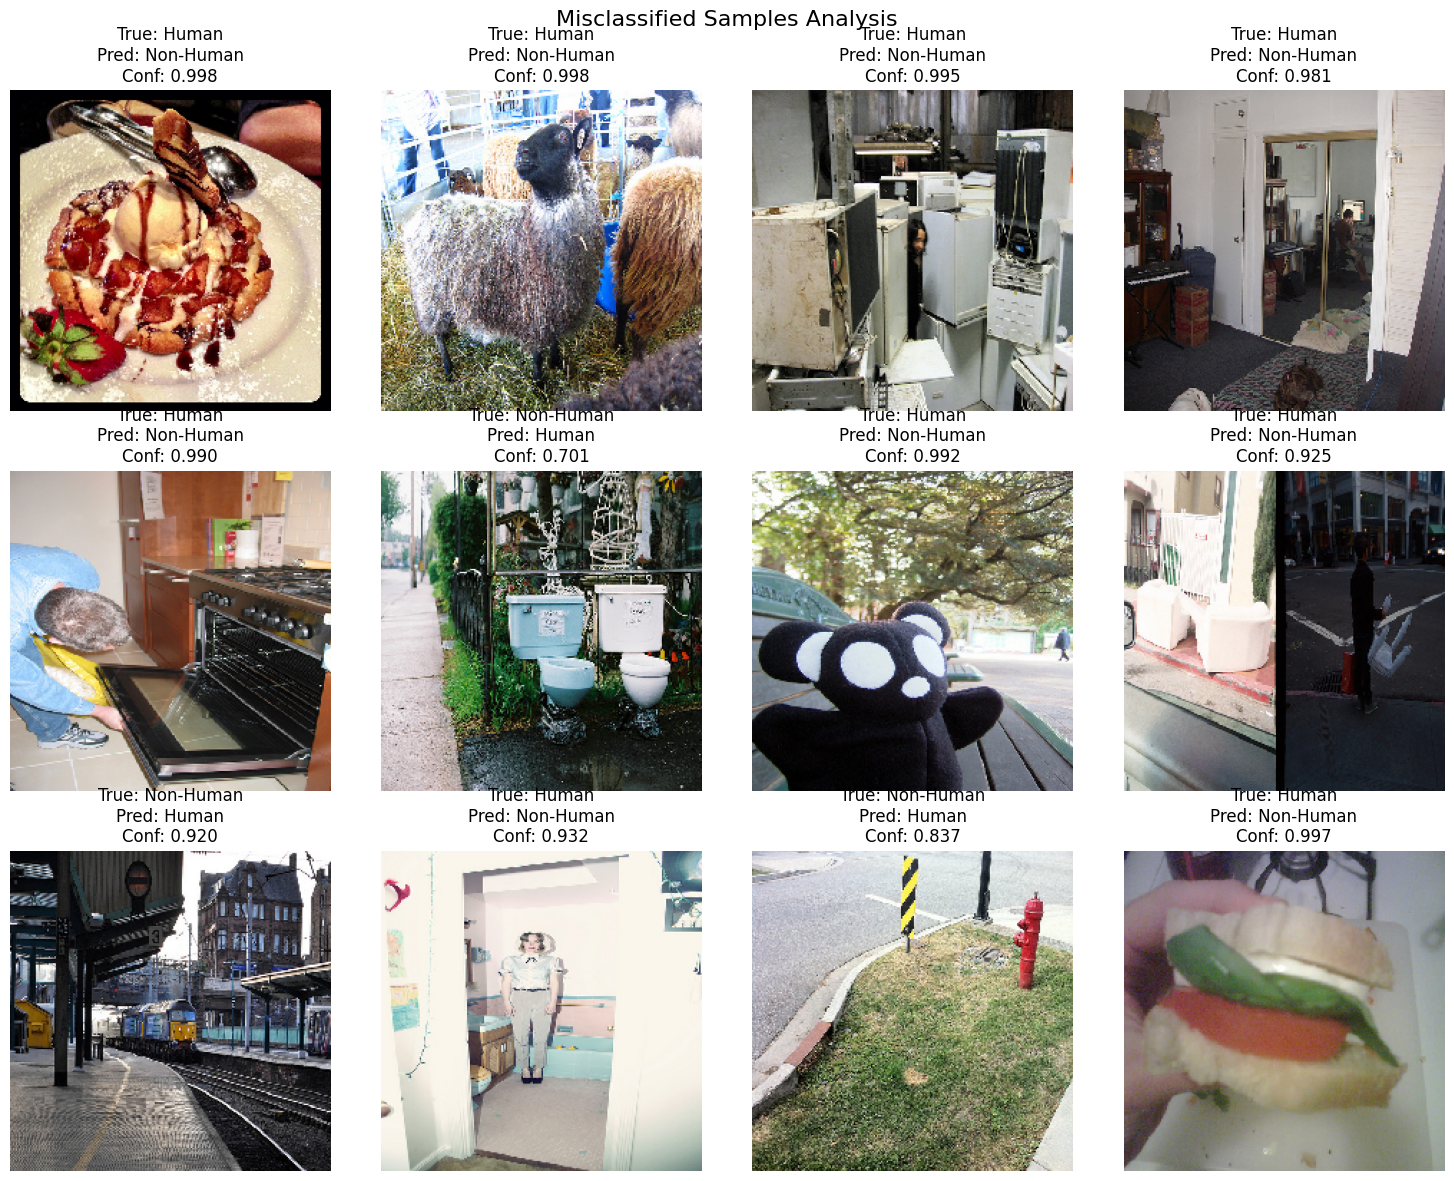

📊 Misclassification Analysis:
   Total misclassifications: 23
   Misclassification rate: 4.96%

🎉 SUCCESS! Model achieved 95.04% accuracy!
✅ Target of 90%+ accuracy has been reached!

✅ Comprehensive evaluation completed!
💾 Results saved to evaluation_results.pkl


In [ ]:
# Cell 8: Comprehensive Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
import itertools

def evaluate_model_comprehensive(model, test_gen, class_names):
    """Comprehensive model evaluation with multiple metrics"""

    print("🔍 Performing comprehensive model evaluation...")

    # Basic evaluation
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_gen, verbose=0)

    # Get predictions
    test_gen.reset()
    predictions = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_gen.classes

    # Calculate F1 score
    from sklearn.metrics import f1_score
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\n📊 Test Set Performance:")
    print(f"   Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"   Test Loss: {test_loss:.4f}")
    print(f"   Test Precision: {test_precision:.4f}")
    print(f"   Test Recall: {test_recall:.4f}")
    print(f"   Test F1-Score: {f1:.4f}")

    # Detailed classification report
    print(f"\n📋 Detailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))

    # Plot confusion matrix
    plt.subplot(2, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Plot ROC curve
    plt.subplot(2, 2, 2)
    fpr, tpr, _ = roc_curve(y_true, predictions[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # Plot Precision-Recall curve
    plt.subplot(2, 2, 3)
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, predictions[:, 1])
    avg_precision = average_precision_score(y_true, predictions[:, 1])
    plt.plot(recall_curve, precision_curve, color='blue', lw=2,
             label=f'PR curve (AP = {avg_precision:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    # Plot prediction confidence distribution
    plt.subplot(2, 2, 4)
    confidence_scores = np.max(predictions, axis=1)
    plt.hist(confidence_scores, bins=20, alpha=0.7, color='green')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Frequency')
    plt.title('Prediction Confidence Distribution')

    plt.tight_layout()
    plt.savefig('comprehensive_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()

    return {
        'accuracy': test_accuracy,
        'loss': test_loss,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': f1,
        'auc_score': roc_auc,
        'predictions': predictions,
        'y_true': y_true,
        'y_pred': y_pred
    }

def analyze_misclassifications(model, test_gen, results, num_samples=12):
    """Analyze misclassified samples"""

    print("🔍 Analyzing misclassified samples...")

    # Get misclassified indices
    misclassified_indices = np.where(results['y_true'] != results['y_pred'])[0]

    if len(misclassified_indices) == 0:
        print("🎉 No misclassifications found!")
        return

    # Sample some misclassified images
    sample_indices = random.sample(list(misclassified_indices),
                                 min(num_samples, len(misclassified_indices)))

    plt.figure(figsize=(15, 12))

    for i, idx in enumerate(sample_indices):
        plt.subplot(3, 4, i + 1)

        # Get image
        test_gen.reset()
        batch_index = idx // test_gen.batch_size
        image_index = idx % test_gen.batch_size

        # Skip to the correct batch
        for _ in range(batch_index + 1):
            batch_x, batch_y = next(test_gen)

        image = batch_x[image_index]
        true_class = results['y_true'][idx]
        pred_class = results['y_pred'][idx]
        confidence = np.max(results['predictions'][idx])

        # Display image
        plt.imshow(image)
        plt.title(f'True: {class_names[true_class]}\nPred: {class_names[pred_class]}\nConf: {confidence:.3f}')
        plt.axis('off')

    plt.suptitle('Misclassified Samples Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()

    print(f"📊 Misclassification Analysis:")
    print(f"   Total misclassifications: {len(misclassified_indices)}")
    print(f"   Misclassification rate: {len(misclassified_indices)/len(results['y_true'])*100:.2f}%")

# Load the best model
print("📁 Loading best trained model...")
try:
    best_model = tf.keras.models.load_model("fine_tuned_human_detection_model.h5")
    print("✅ Fine-tuned model loaded successfully!")
except:
    print("⚠️ Fine-tuned model not found, using current model...")
    best_model = model

# Define class names
class_names = ['Human', 'Non-Human']

# Perform comprehensive evaluation
evaluation_results = evaluate_model_comprehensive(best_model, test_gen, class_names)

# Analyze misclassifications
analyze_misclassifications(best_model, test_gen, evaluation_results)

# Check if we achieved 90%+ accuracy
if evaluation_results['accuracy'] >= 0.90:
    print(f"\n🎉 SUCCESS! Model achieved {evaluation_results['accuracy']*100:.2f}% accuracy!")
    print("✅ Target of 90%+ accuracy has been reached!")
else:
    print(f"\n⚠️ Model achieved {evaluation_results['accuracy']*100:.2f}% accuracy")
    print("📈 Consider further hyperparameter tuning or data augmentation")

# Save evaluation results
import pickle
with open('evaluation_results.pkl', 'wb') as f:
    pickle.dump(evaluation_results, f)

print("\n✅ Comprehensive evaluation completed!")
print("💾 Results saved to evaluation_results.pkl")

✅ Model loaded from fine_tuned_human_detection_model.h5
🔍 Testing with 6 sample images from validation set...

📊 Testing Human Images:


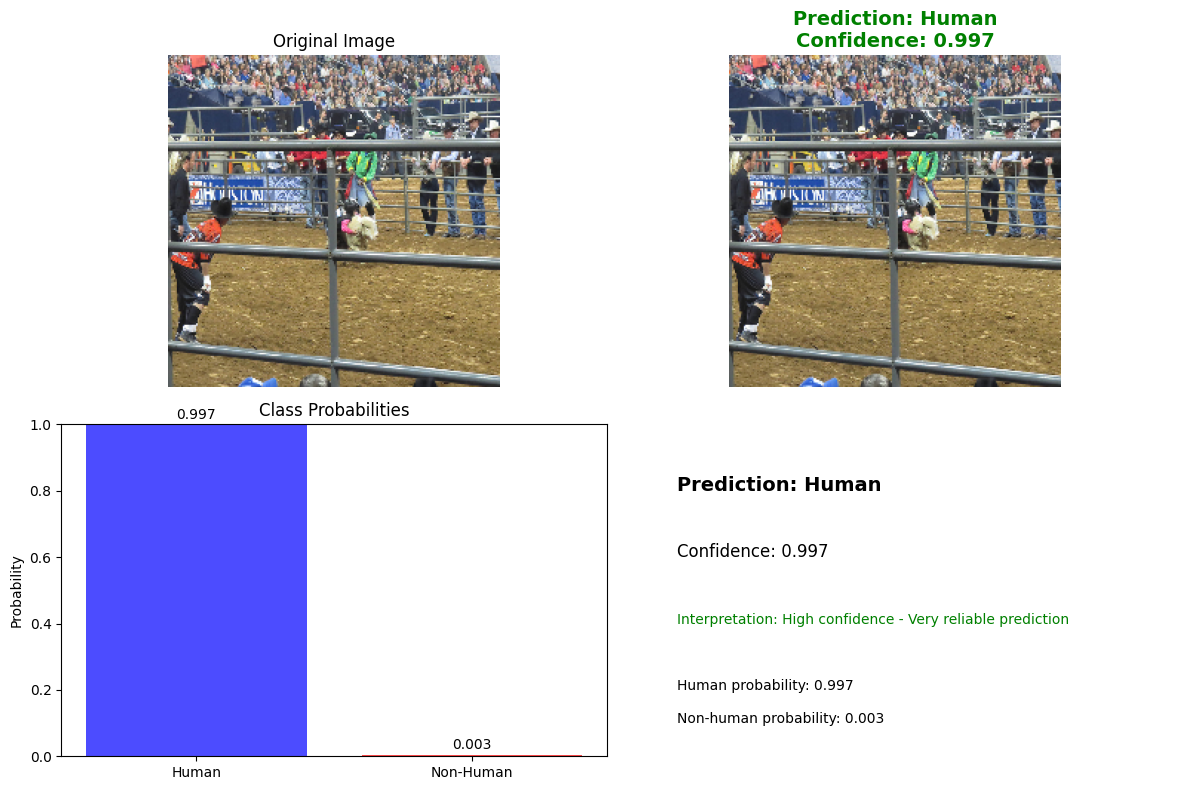

   coco_human_000000156071.jpg: Human (confidence: 0.997)


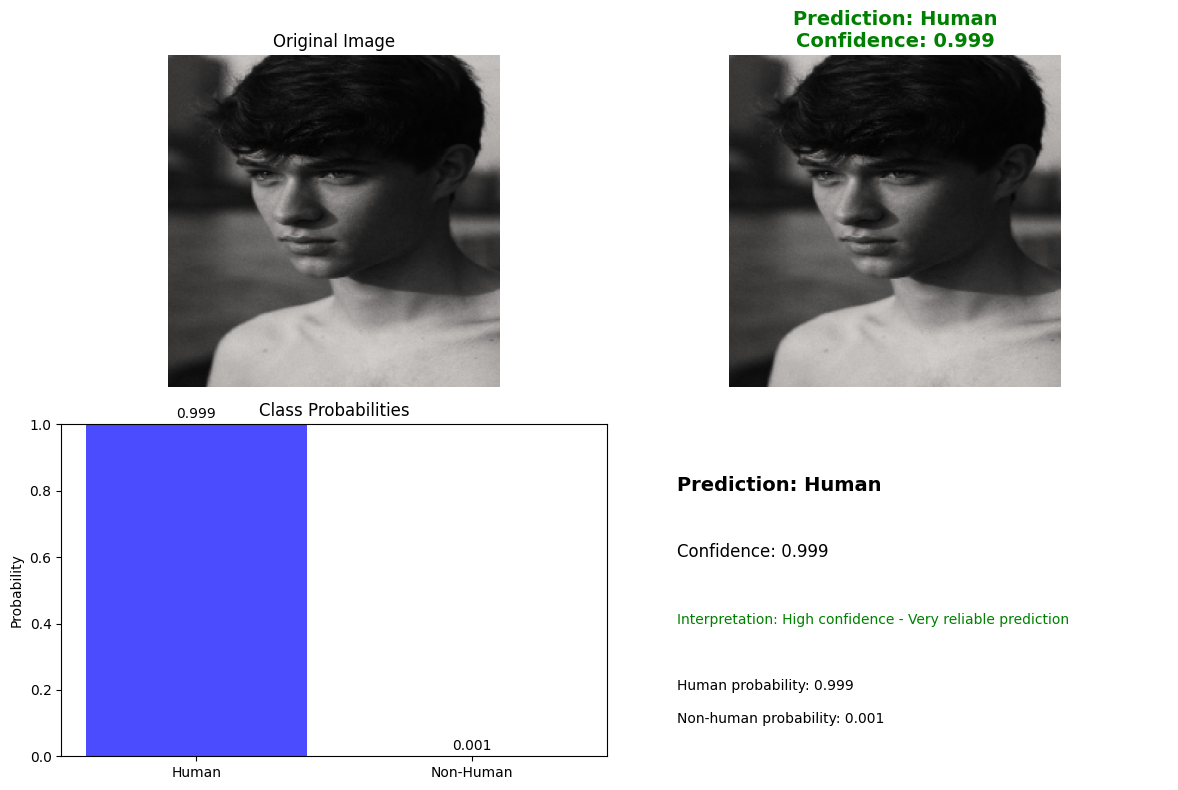

   kaggle_faces_1 (52).png: Human (confidence: 0.999)


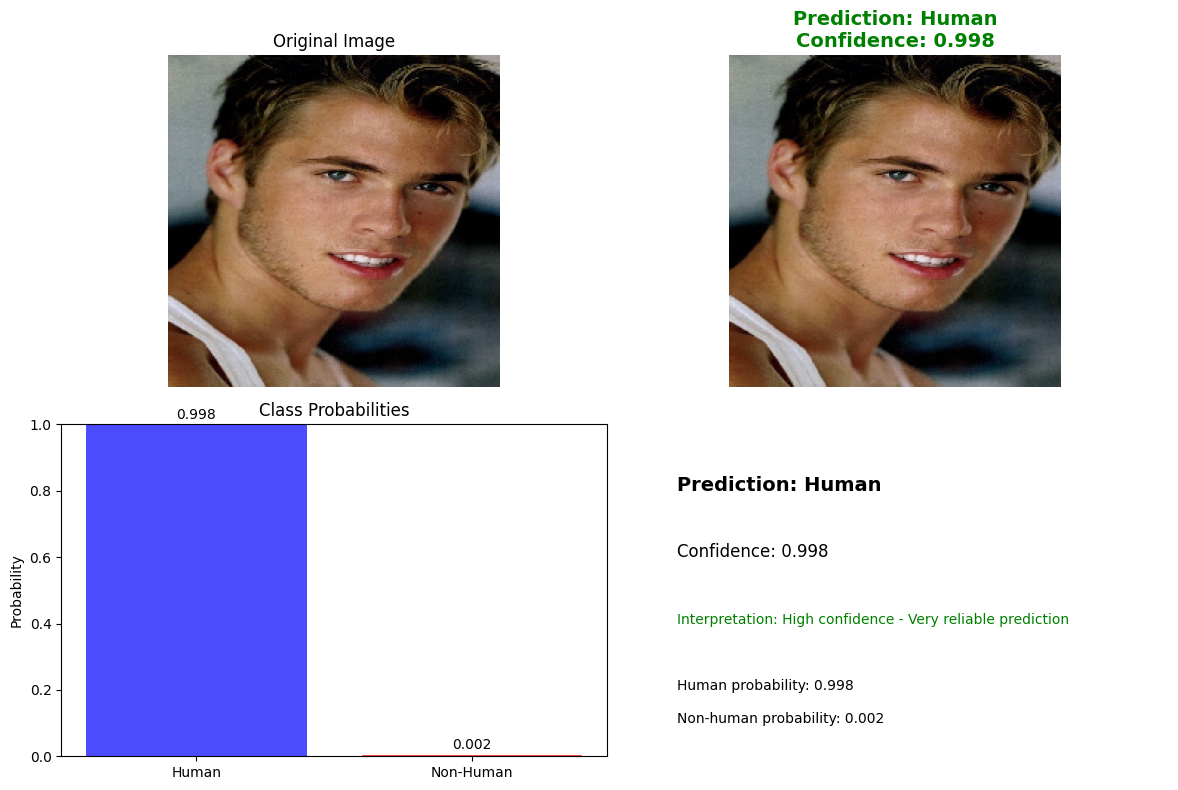

   kaggle_faces_1 (2384).jpg: Human (confidence: 0.998)

📊 Testing Non-Human Images:


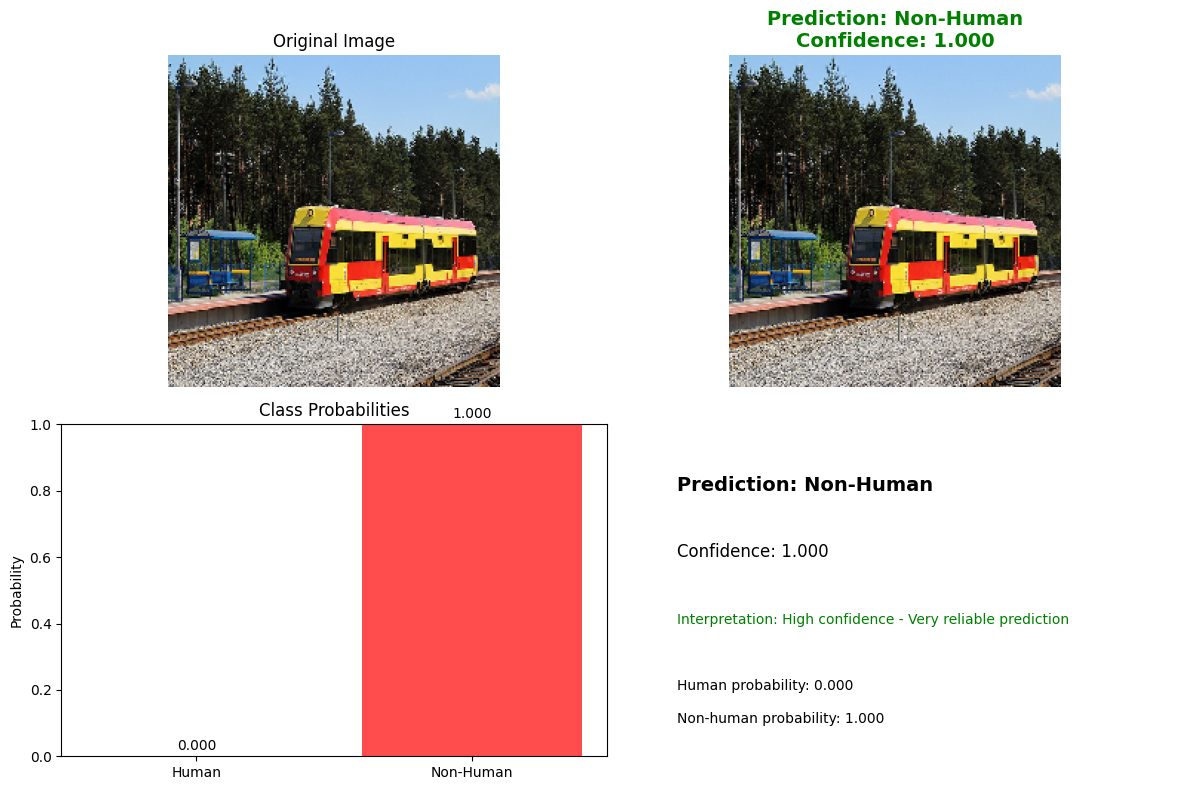

   coco_non_human_000000206994.jpg: Non-Human (confidence: 1.000)


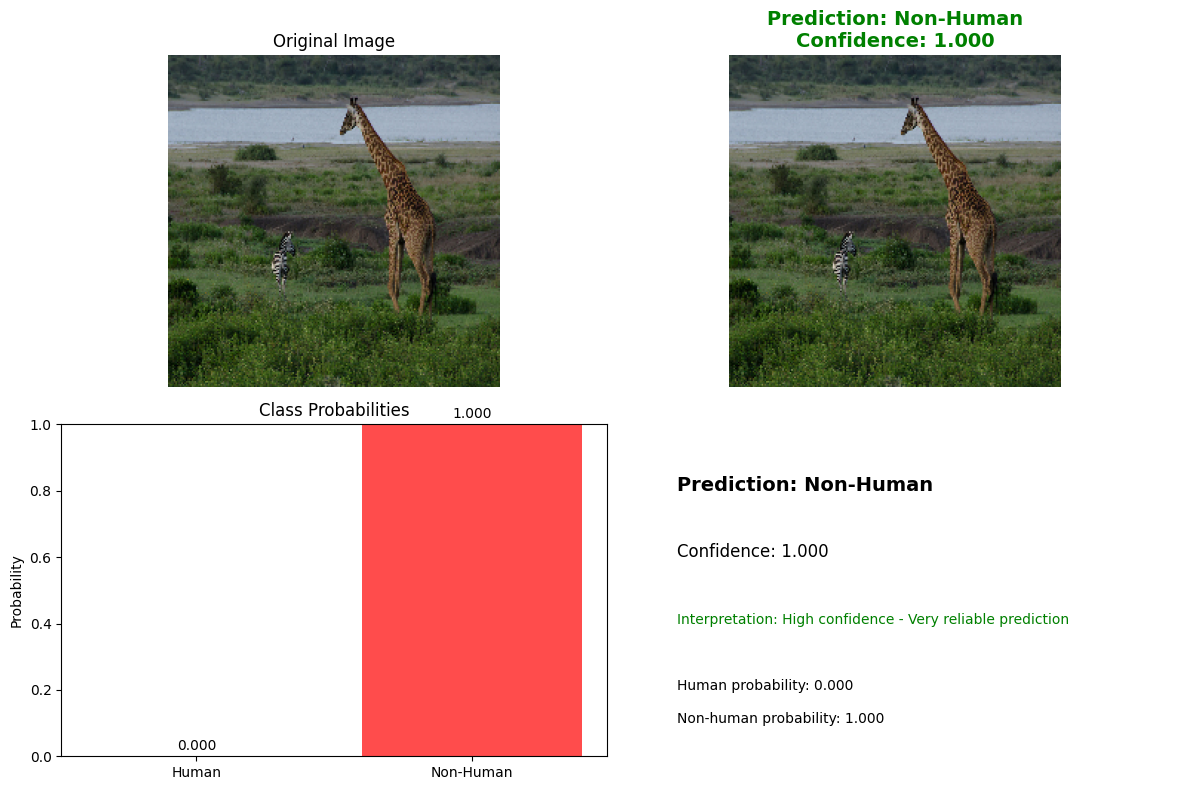

   coco_non_human_000000159977.jpg: Non-Human (confidence: 1.000)


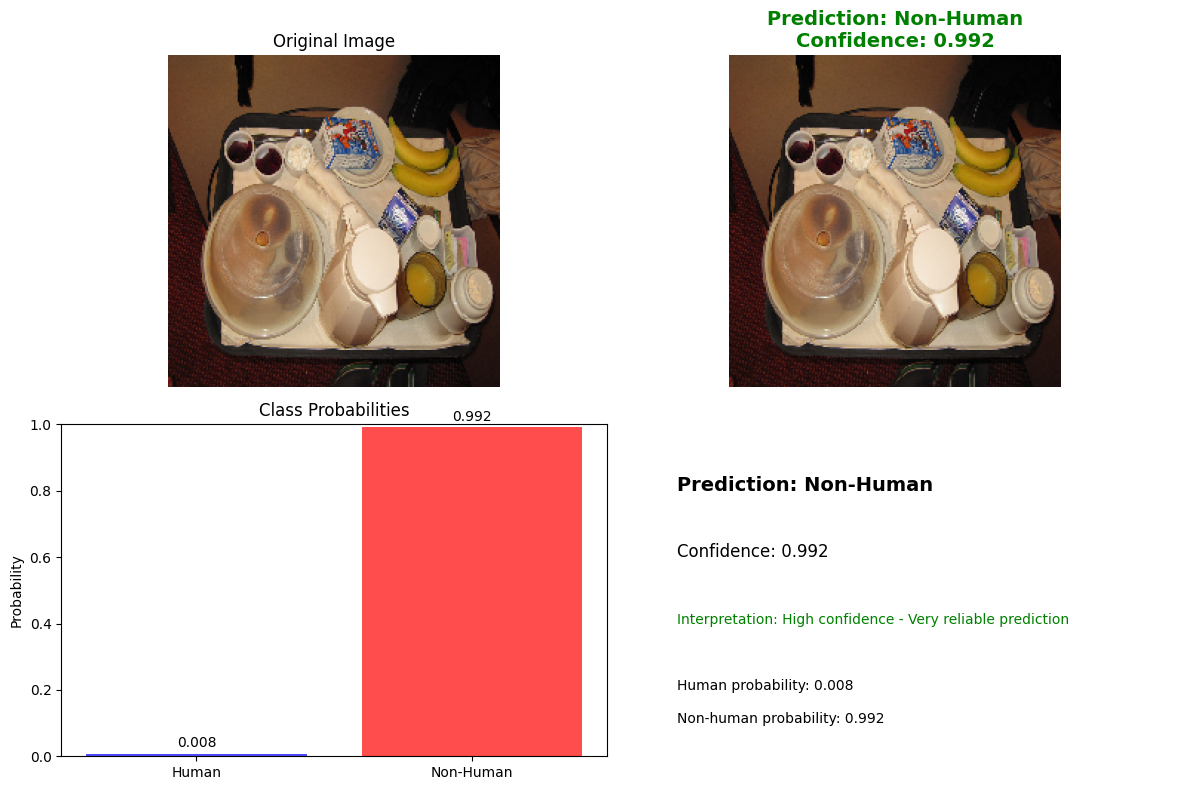

   coco_non_human_000000236721.jpg: Non-Human (confidence: 0.992)

🚀 Human Detection Prediction System Ready!
📤 Run upload_and_test() to test with your own images
📁 Run predictor.batch_predict('/path/to/folder') for batch processing


In [ ]:
# Cell 9: Advanced Prediction System
import cv2
from tensorflow.keras.preprocessing import image
import gradio as gr
from IPython.display import display, HTML

class HumanDetectionPredictor:
    """Advanced Human Detection Prediction System"""

    def __init__(self, model_path="fine_tuned_human_detection_model.h5"):
        """Initialize the predictor with trained model"""
        try:
            self.model = tf.keras.models.load_model(model_path)
            print(f"✅ Model loaded from {model_path}")
        except:
            print("⚠️ Using current model in memory")
            self.model = best_model

        self.class_names = ['Human', 'Non-Human']
        self.img_size = (224, 224)

    def preprocess_image(self, img_path):
        """Preprocess image for prediction"""
        try:
            # Load image
            img = image.load_img(img_path, target_size=self.img_size)
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = img_array / 255.0

            return img_array, img
        except Exception as e:
            print(f"❌ Error preprocessing image: {e}")
            return None, None

    def predict_single_image(self, img_path, show_visualization=True):
        """Predict single image with detailed analysis"""

        # Preprocess image
        img_array, original_img = self.preprocess_image(img_path)

        if img_array is None:
            return None

        # Make prediction
        predictions = self.model.predict(img_array, verbose=0)
        predicted_class_idx = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_idx]
        predicted_class = self.class_names[predicted_class_idx]

        # Get probabilities for both classes
        human_prob = predictions[0][0]
        non_human_prob = predictions[0][1]

        # Create visualization
        if show_visualization:
            plt.figure(figsize=(12, 8))

            # Display original image
            plt.subplot(2, 2, 1)
            plt.imshow(original_img)
            plt.title(f'Original Image')
            plt.axis('off')

            # Display prediction
            plt.subplot(2, 2, 2)
            plt.imshow(original_img)
            color = 'green' if confidence > 0.8 else 'orange' if confidence > 0.6 else 'red'
            plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence:.3f}',
                     color=color, fontsize=14, fontweight='bold')
            plt.axis('off')

            # Display probability distribution
            plt.subplot(2, 2, 3)
            classes = ['Human', 'Non-Human']
            probs = [human_prob, non_human_prob]
            bars = plt.bar(classes, probs, color=['blue', 'red'], alpha=0.7)
            plt.title('Class Probabilities')
            plt.ylabel('Probability')
            plt.ylim(0, 1)

            # Add value labels on bars
            for bar, prob in zip(bars, probs):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{prob:.3f}', ha='center', va='bottom')

            # Display confidence interpretation
            plt.subplot(2, 2, 4)
            plt.text(0.1, 0.8, f'Prediction: {predicted_class}', fontsize=14, fontweight='bold')
            plt.text(0.1, 0.6, f'Confidence: {confidence:.3f}', fontsize=12)

            if confidence > 0.8:
                interpretation = "High confidence - Very reliable prediction"
                color = 'green'
            elif confidence > 0.6:
                interpretation = "Moderate confidence - Generally reliable"
                color = 'orange'
            else:
                interpretation = "Low confidence - Consider manual review"
                color = 'red'

            plt.text(0.1, 0.4, f'Interpretation: {interpretation}',
                    fontsize=10, color=color, wrap=True)
            plt.text(0.1, 0.2, f'Human probability: {human_prob:.3f}', fontsize=10)
            plt.text(0.1, 0.1, f'Non-human probability: {non_human_prob:.3f}', fontsize=10)

            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        return {
            'predicted_class': predicted_class,
            'confidence': confidence,
            'human_probability': human_prob,
            'non_human_probability': non_human_prob,
            'all_predictions': predictions[0]
        }

    def batch_predict(self, image_folder, output_csv=None):
        """Predict multiple images in a folder"""

        # Get all image files
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
        image_files = []

        for ext in image_extensions:
            image_files.extend(glob.glob(os.path.join(image_folder, f'*{ext}')))
            image_files.extend(glob.glob(os.path.join(image_folder, f'*{ext.upper()}')))

        if not image_files:
            print(f"❌ No images found in {image_folder}")
            return None

        print(f"🔍 Processing {len(image_files)} images...")

        results = []

        for i, img_path in enumerate(image_files):
            print(f"Processing {i+1}/{len(image_files)}: {os.path.basename(img_path)}")

            result = self.predict_single_image(img_path, show_visualization=False)

            if result:
                results.append({
                    'image_path': img_path,
                    'filename': os.path.basename(img_path),
                    'predicted_class': result['predicted_class'],
                    'confidence': result['confidence'],
                    'human_probability': result['human_probability'],
                    'non_human_probability': result['non_human_probability']
                })

        # Create summary
        if results:
            human_count = sum(1 for r in results if r['predicted_class'] == 'Human')
            non_human_count = len(results) - human_count
            avg_confidence = np.mean([r['confidence'] for r in results])

            print(f"\n📊 Batch Prediction Summary:")
            print(f"   Total images processed: {len(results)}")
            print(f"   Human images: {human_count}")
            print(f"   Non-human images: {non_human_count}")
            print(f"   Average confidence: {avg_confidence:.3f}")

            # Save to CSV if requested
            if output_csv:
                import pandas as pd
                df = pd.DataFrame(results)
                df.to_csv(output_csv, index=False)
                print(f"💾 Results saved to {output_csv}")

        return results

# Initialize predictor
predictor = HumanDetectionPredictor()

# Upload and test function
def upload_and_test():
    """Upload and test custom images"""
    from google.colab import files

    print("📤 Upload your images to test the human detection model")
    uploaded_files = files.upload()

    if uploaded_files:
        print(f"\n✅ {len(uploaded_files)} file(s) uploaded successfully!")

        for filename in uploaded_files.keys():
            print(f"\n🔍 Analyzing: {filename}")

            img_path = f"/content/{filename}"
            result = predictor.predict_single_image(img_path)

            if result:
                print(f"📊 Result Summary:")
                print(f"   Predicted Class: {result['predicted_class']}")
                print(f"   Confidence: {result['confidence']:.3f}")
                print(f"   Human Probability: {result['human_probability']:.3f}")
                print(f"   Non-Human Probability: {result['non_human_probability']:.3f}")

                # Interpretation
                if result['confidence'] > 0.8:
                    print("🎯 High confidence prediction!")
                elif result['confidence'] > 0.6:
                    print("⚠️ Moderate confidence prediction")
                else:
                    print("⚠️ Low confidence - consider manual review")
    else:
        print("❌ No files uploaded")

# Test with sample images from validation set
def test_with_sample_images(num_samples=5):
    """Test with sample images from validation set"""

    print(f"🔍 Testing with {num_samples} sample images from validation set...")

    # Get sample images
    val_human_dir = os.path.join(balanced_dataset_dir, 'val', 'human')
    val_non_human_dir = os.path.join(balanced_dataset_dir, 'val', 'non_human')

    human_samples = random.sample(os.listdir(val_human_dir), min(num_samples//2, len(os.listdir(val_human_dir))))
    non_human_samples = random.sample(os.listdir(val_non_human_dir), min(num_samples//2, len(os.listdir(val_non_human_dir))))

    print("\n📊 Testing Human Images:")
    for img in human_samples:
        img_path = os.path.join(val_human_dir, img)
        result = predictor.predict_single_image(img_path)
        print(f"   {img}: {result['predicted_class']} (confidence: {result['confidence']:.3f})")

    print("\n📊 Testing Non-Human Images:")
    for img in non_human_samples:
        img_path = os.path.join(val_non_human_dir, img)
        result = predictor.predict_single_image(img_path)
        print(f"   {img}: {result['predicted_class']} (confidence: {result['confidence']:.3f})")

# Test with sample images
test_with_sample_images(6)

print("\n🚀 Human Detection Prediction System Ready!")
print("📤 Run upload_and_test() to test with your own images")
print("📁 Run predictor.batch_predict('/path/to/folder') for batch processing")

Saving t.jpg to t.jpg

🔍 Testing image: t.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


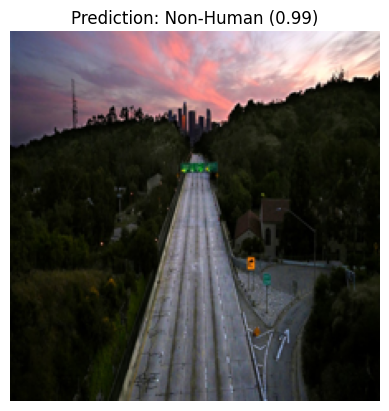

✅ Prediction: Non-Human with 0.99 confidence


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('fine_tuned_human_detection_model.h5')

# Define class names
class_names = ['Human', 'Non-Human']

# Function to load, preprocess and predict
def predict_image(image_path):
    # Load and preprocess the image
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img) / 255.0  # normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # batch dimension

    # Make prediction
    prediction = model.predict(img_array)[0]
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)

    # Display image and result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class} ({confidence:.2f})")
    plt.show()

    return predicted_class, confidence

# Upload your own image
from google.colab import files
uploaded = files.upload()

# Predict the uploaded image
for filename in uploaded.keys():
    print(f"\n🔍 Testing image: {filename}")
    predicted_class, confidence = predict_image(filename)
    print(f"✅ Prediction: {predicted_class} with {confidence:.2f} confidence")
